In [6]:
import numpy as np
import scipy
import librosa as lb
from scipy.signal import hamming
from matplotlib import pyplot as plt
from audiolazy import lazy_lpc as lpc
from IPython.display import Audio 
from IPython.core.display import display
import librosa as lb

In [8]:
# interactive plotting
plt.ion()

In [9]:
def est_predictor_gain(x, a, p):
    '''
    A function to compute gain of the residual signal in LP analyis.
    x:  signal 
    a: LPC coefficients
    p: order of the filter
    '''
    cor = np.correlate(x, x, mode='full')
    
    rr = cor[len(cor)//2: len(cor)//2+p+1]
    g = np.sqrt(np.sum(a*rr))
    return g
   
def reject_outliers(data, m=2):
    '''
    Function to reject outliers. All values beyond m standard deviations from means are excluded
    '''
    return data[abs(data - np.mean(data)) < m * np.std(data)]


In [19]:
def LPA(audio, p, title):
    # # read audio
    audioIn, fs=lb.load(audio, sr=None)   

    # number of DFT points
    nfft = 1024

    inInd =0
    wLen = int(0.02*fs) # 20 ms window
    win = hamming(wLen) # hamming window for example

    cnt = 0
    numframes = np.ceil( (len(audioIn)-wLen)/(wLen/2)) # number of franes 
    formants  = []                                     # A placeholder for storing formants

    # choose a representative frame of the vowel
    plot_frame = int(numframes/2)  # middle of the vowel

    # The analysis loop
    while inInd< len(audioIn)-wLen:
        
        # audio frame
        frame = audioIn[inInd:inInd+wLen]* win    
        
        
        #frame = reject_outliers(frame, m=2)
        # compute LPC and gain 
        
        #LPC = lb.autocorrelate(frame)
        LPC=lpc.lpc.autocor(frame,order=p).numerator
        g=est_predictor_gain(frame, LPC, p)
        
        # Compute the filter tansfer function
        w, h = scipy.signal.freqz(g, a=LPC, fs=fs)
        
        # Compute DFT spectrum
        DFT=np.abs(scipy.fft.fft(frame,n=nfft))
        
    # Problem 2: ​Formant analysis.    
        # Compute roots of
        roots=np.roots(LPC)
           
        #  LPC coefficients are real-valued, the roots occur in complex conjugate pairs.
        # Retain only the roots with +ve sign for the imaginary part 
        

        roots = roots[np.imag(roots) >= 0]
        
        # compute formants from roots
        angz=np.angle(roots)
    
        # convert to Hertz from angular frequencies
        angz = angz*(fs/(2*np.pi))
    
        # sort the formants in increasing order
        angz = np.sort(angz)
        
        # remove zero frequencies
        angz = angz[angz !=0]
        
        # First three formants
        if angz[:3].shape!=(0,):
            formants.append(angz[:3]) 
        
        inInd = inInd + int(wLen/2) # frame advance
        
        cnt = cnt+1 
        
        # plot the FFT spectrum and LPC spectrum here for chosen frame
        if cnt == plot_frame :
            # plot DFT spectrum (remember both in dB scale)
            line = np.linspace(0, fs/2, nfft//2)
            plt.plot(line, np.log(DFT[0:int(nfft/2)]), label="DFT spectrum")
            # plot LPC spectrum
            plt.plot(w, np.log(np.abs(h)), label="LPC spectrum")
            plt.title(title)
            plt.legend(loc="upper left")
            plt.show()
    formants = np.array(formants)
    print('------ The computed formants are :', np.mean(formants, 0))

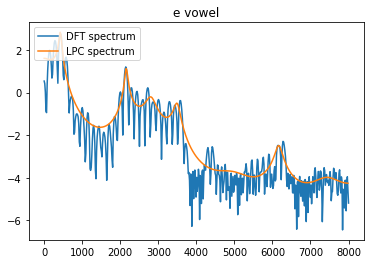

------ The computed formants are : [ 396.05136913 2010.92518954 2719.47215484]


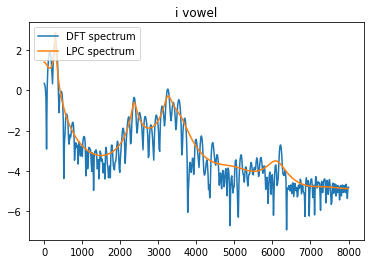

------ The computed formants are : [ 320.96257536 2310.50977023 3255.00962328]


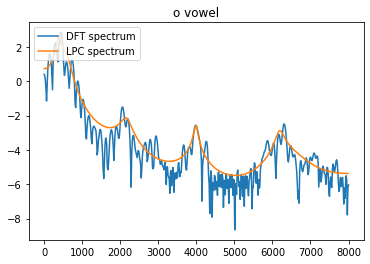

------ The computed formants are : [ 422.79885011  823.79623368 2231.92986222]


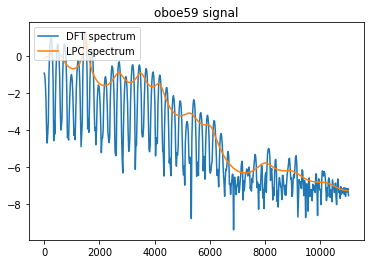

------ The computed formants are : [ 521.59252566 1440.88351218 2592.89969916]


In [20]:
LPA('e.wav', 16, "e vowel")

LPA('i.wav', 16, "i vowel")

LPA('o.wav', 16, "o vowel")

#BONUS
LPA('oboe59.wav', 22, "oboe59 signal")



Linear Predictive Coding (LPC) analysis tries to determine the formant frequencies, or peaks in the dft spectrum.
In addition the connection between LPC model order and peaks of dft spectrum is that number of coefficients (lpc model order) should be twice the number of peaks i.e, formants.  